In [36]:
# Import libraries
import numpy as np
import pandas as pd

from time import time

from sklearn.metrics import f1_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import KFold

from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Read data
data = pd.read_csv("winequality-red.csv", header=0, index_col=False)

## Explorando os dados

In [37]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [38]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


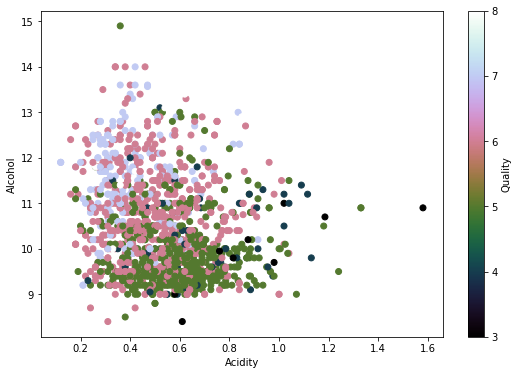

In [39]:
plt.figure(figsize=(9, 6))

plt.scatter(data['volatile acidity'].values, data['alcohol'].values, c=data['quality'].values, cmap=plt.cm.cubehelix)

plt.xlabel('Acidity')
plt.ylabel('Alcohol')

cbar = plt.colorbar()
cbar.set_label("Quality")

plt.show()

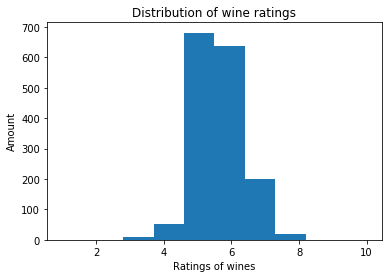

In [40]:
plt.hist(data['quality'], range=(1, 10))

plt.xlabel('Ratings of wines')
plt.ylabel('Amount')
plt.title('Distribution of wine ratings')
plt.show()

## Preparando os dados

### Identificando as features

In [41]:
features = list(data.columns[:-1])
resultado = data.columns[-1]

print features
print len(features)
print 
print resultado

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
11

quality


### Preprocessando as features

In [42]:
#vinhos serão considerados ruins < 6
data['quality'].replace([1,2,3,4,5], 0,inplace=True)

#vinhos serão considerados bons >= 6
data['quality'].replace([6,7,8,9,10], 1,inplace=True)

data = data.sample(frac=1).reset_index(drop=True)

from sklearn import preprocessing

features_valores = data[features]
resultado_valores = data[resultado]

print features_valores.head()
print
print features_valores.describe()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.0              1.18         0.21             1.9      0.083   
1            7.0              0.69         0.07             2.5      0.091   
2            7.2              0.45         0.15             2.0      0.078   
3           11.5              0.42         0.48             2.6      0.077   
4           10.8              0.47         0.43             2.1      0.171   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 14.0                  41.0  0.99532  3.34       0.47   
1                 15.0                  21.0  0.99572  3.38       0.60   
2                 10.0                  28.0  0.99609  3.29       0.51   
3                  8.0                  20.0  0.99852  3.09       0.53   
4                 27.0                  66.0  0.99820  3.17       0.76   

   alcohol  
0     10.5  
1     11.3  
2      9.9  
3     11.0  
4     10.8  

       

### Treino e Teste - Data split

In [43]:
train_size = 600

test_size = data.shape[0] - train_size

X_train, X_test, y_train, y_test = train_test_split(features_valores, resultado_valores, train_size=train_size, random_state=42)
print "Treino"
print X_train.shape[0]
print
print "Teste"
print X_test.shape[0]

Treino
600

Teste
999


## Treino

In [44]:
table_line = ""

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    global table_line
    table_line += " {:.4f} |".format(end - start)
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target, train):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    global table_line
    if train:
        table_line += " {:.4f} |".format(end - start)
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label=1)


def train_predict(clf, X_train, y_train, X_test, y_test):
    global table_line
    table_line += "\n | {} |".format(len(X_train))
    
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    training_s = predict_labels(clf, X_train, y_train, True)
    test_s = predict_labels(clf, X_test, y_test, False)
    
    table_line += " {:.4f} |".format(training_s)
    table_line += " {:.4f} |".format(test_s)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(training_s)
    print "F1 score for test set: {:.4f}.".format(test_s)

In [45]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm

# TODO: Initialize the three models
clf_A = svm.SVC(random_state=42)
clf_B = RandomForestClassifier(max_depth=7, random_state=42)
clf_C = GradientBoostingClassifier(max_depth=7,random_state=42)

# TODO: Set up the training set sizes
for clf in [clf_A, clf_B, clf_C]:
    for size in [150, 300, 600]:
        train_predict(clf, X_train[:size], y_train[:size], X_test, y_test)
    print '='*80 # imprime linha
print table_line

Training a SVC using a training set size of 150. . .
Trained model in 0.0055 seconds
Made predictions in 0.0011 seconds.
Made predictions in 0.0057 seconds.
F1 score for training set: 0.9452.
F1 score for test set: 0.5386.
Training a SVC using a training set size of 300. . .
Trained model in 0.0056 seconds
Made predictions in 0.0033 seconds.
Made predictions in 0.0102 seconds.
F1 score for training set: 0.9315.
F1 score for test set: 0.5365.
Training a SVC using a training set size of 600. . .
Trained model in 0.0199 seconds
Made predictions in 0.0116 seconds.
Made predictions in 0.0191 seconds.
F1 score for training set: 0.8917.
F1 score for test set: 0.6705.
Training a RandomForestClassifier using a training set size of 150. . .
Trained model in 0.0703 seconds
Made predictions in 0.0011 seconds.
Made predictions in 0.0015 seconds.
F1 score for training set: 0.9863.
F1 score for test set: 0.7139.
Training a RandomForestClassifier using a training set size of 300. . .
Trained model in 

** Classifer 1 - SVM**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 150 | 0.0055 | 0.0011 | 0.9452 | 0.5386 |
 | 300 | 0.0056 | 0.0033 | 0.9315 | 0.5365 |
 | 600 | 0.0199 | 0.0116 | 0.8917 | 0.6705 |
 
** Classifer 2 - RandomForestClassifier**

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 150 | 0.0703 | 0.0011 | 0.9863 | 0.7139 |
 | 300 | 0.0239 | 0.0014 | 0.9347 | 0.7507 |
 | 600 | 0.0437 | 0.0023 | 0.9208 | 0.7660 |

** Classifer 3 - GradientBoostingClassifier**

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
 | 150 | 0.1360 | 0.0009 | 1.0000 | 0.7068 |
 | 300 | 0.2504 | 0.0022 | 1.0000 | 0.7488 |
 | 600 | 0.3435 | 0.0034 | 1.0000 | 0.7843 |

## Removendo os outliers

In [46]:
for col, col_data in data.iteritems():
    if col != 'quality':
        print col
        data = data[data[col] > data[col].mean() - 2 * data[col].std()]
        data = data[data[col] < data[col].mean() + 2 * data[col].std()]
    
print data.head()

print data.describe()
    
    

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1            7.0             0.690         0.07             2.5      0.091   
2            7.2             0.450         0.15             2.0      0.078   
3           11.5             0.420         0.48             2.6      0.077   
5            7.7             0.715         0.01             2.1      0.064   
6            8.7             0.420         0.45             2.4      0.072   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1                 15.0                  21.0  0.99572  3.38       0.60   
2                 10.0                  28.0  0.99609  3.29       0.51   
3                  8.0                  20.0  0.99852  3.09       0.53   
5                 31.0                  43.0  0.99371  3.41       0.57   
6                 32.0 

### Treino e Teste - Data split

In [47]:
features_valores = data[features]
resultado_valores = data[resultado]

train_size = 600

test_size = data.shape[0] - train_size

X_train, X_test, y_train, y_test = train_test_split(features_valores, resultado_valores, train_size=train_size, random_state=42)
print "Treino"
print X_train.shape[0]
print
print "Teste"
print X_test.shape[0]

Treino
600

Teste
373


## Escolhendo o melhor modelo

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

parameters = [
    { 'n_estimators' : [100], 'min_samples_leaf': [1,2,3]}
]


clf = RandomForestClassifier(max_depth=7, random_state=42)

f1_scorer = metrics.make_scorer(metrics.f1_score, pos_label=1)

grid_obj = GridSearchCV(clf, parameters, f1_scorer)

grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train, False))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test, False))

Made predictions in 0.0103 seconds.
Tuned model has a training F1 score of 0.9393.
Made predictions in 0.0093 seconds.
Tuned model has a testing F1 score of 0.7708.


In [84]:
import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix


pred_y = clf.predict(X_test)
# print y_test.values
# print pred_y

binary_confusion_matrix = ConfusionMatrix(y_test.values, pred_y)
print("Binary confusion matrix:\n%s" % binary_confusion_matrix)

Binary confusion matrix:
Predicted  False  True  __all__
Actual                         
False        137    35      172
True          53   148      201
__all__      190   183      373


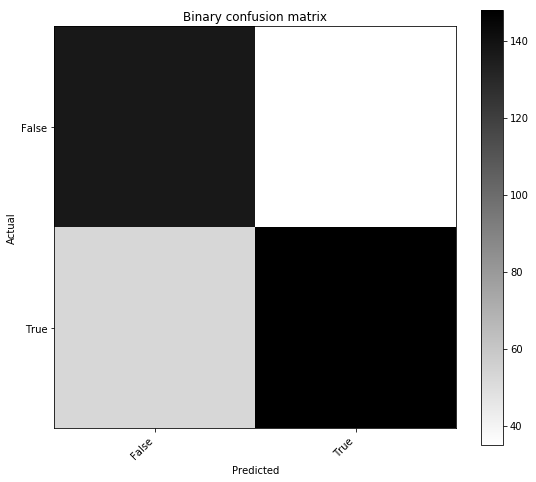

In [85]:
binary_confusion_matrix.plot()
plt.show()